# Extrinsinc Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    
print('Settings loaded!')

Settings loaded!


**Load OSM and reference graphs and grid:**

In [3]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

osm_edges.loc[osm_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_edges.loc[osm_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
osm_simplified_edges['infrastructure_length'] = osm_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

    ref_edges.loc[ref_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_edges.loc[ref_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

print('Data loaded!')

# Data formatting

# TODO: Convert to function?
# creating coulumns with node id and indexes (required by some functions)
osm_simplified_edges['edge_id'] = osm_simplified_edges.reset_index().index
osm_edges['edge_id'] = osm_edges.reset_index().index

u_list = osm_simplified_edges.reset_index()['u'].to_list()
v_list = osm_simplified_edges.reset_index()['v'].to_list()
osm_simplified_edges['u'] = u_list
osm_simplified_edges['v'] = v_list

u_list = osm_edges.reset_index()['u'].to_list()
v_list = osm_edges.reset_index()['v'].to_list()
osm_edges['u'] = u_list
osm_edges['v'] = v_list

osm_simplified_nodes['node_id'] = osm_simplified_nodes.index
osm_nodes['node_id'] = osm_nodes.index

# creating coulumns with node id and indexes (required by some functions)
ref_simplified_edges['edge_id'] = ref_simplified_edges.reset_index().index
ref_edges['edge_id'] = ref_edges.reset_index().index

u_list = ref_simplified_edges.reset_index()['u'].to_list()
v_list = ref_simplified_edges.reset_index()['v'].to_list()
ref_simplified_edges['u'] = u_list
ref_simplified_edges['v'] = v_list

u_list = ref_edges.reset_index()['u'].to_list()
v_list = ref_edges.reset_index()['v'].to_list()
ref_edges['u'] = u_list
ref_edges['v'] = v_list

ref_simplified_nodes['node_id'] = ref_simplified_nodes.index
ref_nodes['node_id'] = ref_nodes.index


Data loaded!


<AxesSubplot:>

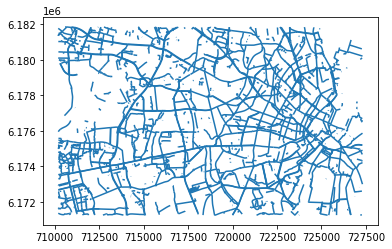

In [4]:
# TODO: Plot
osm_simplified_edges.plot()

<AxesSubplot:>

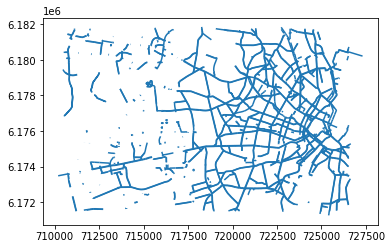

In [5]:
# TODO: Plot
ref_simplified_edges.plot()

**Joining grid cell id to network elements and counting features in each grid:**

In [7]:
# Join grid ids to data 

osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection')
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection')

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection')
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

## General Comparison of Network Structure

In [8]:
osm_edge_percent_diff = (len(osm_edges) - len(osm_simplified_edges)) / len(osm_edges)*100
osm_node_percent_diff = (len(osm_nodes) - len(osm_simplified_nodes)) / len(osm_nodes)*100
print(f'Simplifying the OSM network decreased the number of edges with {osm_edge_percent_diff:.1f}%')
print(f'Simplifying the OSM network decreased the number of nodes with {osm_node_percent_diff:.1f}%')

ref_edge_percent_diff = (len(ref_edges) - len(ref_simplified_edges)) / len(ref_edges)*100
ref_node_percent_diff = (len(ref_nodes) - len(ref_simplified_nodes)) / len(ref_nodes)*100
print(f'Simplifying the reference network decreased the number of edges with {ref_edge_percent_diff:.1f}%')
print(f'Simplifying the reference network decreased the number of nodes with {ref_node_percent_diff:.1f}%')

Simplifying the OSM network decreased the number of edges with 82.7%
Simplifying the OSM network decreased the number of nodes with 84.8%
Simplifying the reference network decreased the number of edges with 60.2%
Simplifying the reference network decreased the number of nodes with 63.5%


**Comparing network length:**

In [9]:
ref_length = ref_simplified_edges.infrastructure_length.sum()

osm_length = osm_simplified_edges.infrastructure_length.sum()

diff = abs(osm_length - ref_length)

percent_diff = (osm_length - ref_length) / osm_length * 100

# TODO: Add plot visualising lenght difference

print(f'There is an {diff/1000:.2f} km length difference between the two datasets')

print(f'The difference between the length of the OSM and the reference data is {percent_diff:.2f} %')

There is an 433.30 km length difference between the two datasets
The difference between the length of the OSM and the reference data is 41.00 %


**Comparing number of nodes and edges:**

In [ ]:
# Total
osm_nodes_count = len(osm_simplified_nodes)
osm_edges_count = len(osm_simplified_edges)

ref_nodes_count = len(ref_simplified_nodes)
ref_edges_count = len(ref_simplified_edges)

print(osm_nodes_count)
print(osm_edges_count)
print(ref_edges_count)
print(ref_nodes_count)

# TODO: Add plot (bars)

**Comparing network density:**

<AxesSubplot:>

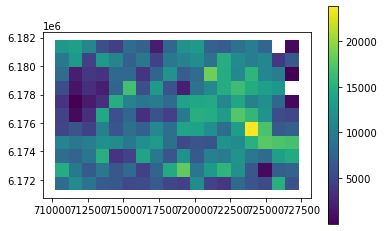

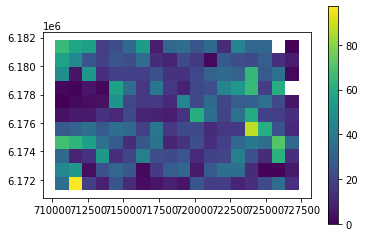

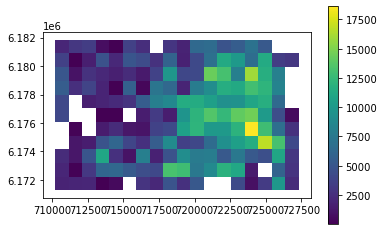

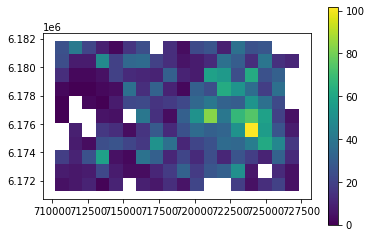

In [10]:
# Per grid cell

results_dict = {}
area = grid.loc[0,'geometry'].area
data = (osm_edges_s_j, osm_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_edge_density',1:'osm_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='osm_edge_density', legend=True)
grid.plot(column='osm_node_density', legend=True)

# Per grid cell

results_dict = {}
area = grid.loc[0,'geometry'].area
data = (ref_edges_s_j, ref_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_edge_density',1:'ref_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='ref_edge_density', legend=True)
grid.plot(column='ref_node_density', legend=True)


**Differences in network density:**

<AxesSubplot:>

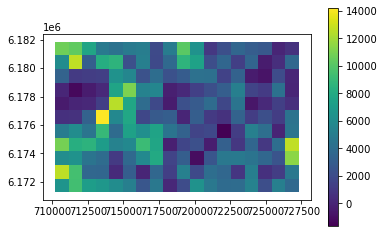

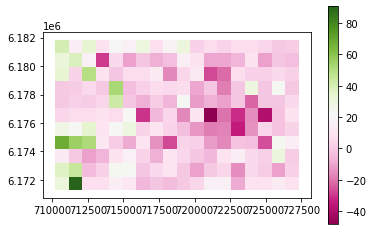

In [11]:
grid['edge_density_diff'] = grid.osm_edge_density.fillna(value=0) - grid.ref_edge_density.fillna(value=0)
grid['node_density_diff'] = grid.osm_node_density.fillna(value=0) - grid.ref_node_density.fillna(value=0)

# TODO: Maybe do not fillna with node density?

# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!
grid.plot(column='edge_density_diff', legend=True)
grid.plot(column='node_density_diff', legend=True, cmap='PiYG')

**Differences in density of different types of cycling infrastructure:**

In [ ]:
# TODO Just compare protected/unprotected

# Reuse function for classifying - make a dictionary defining unprotected or protected
# Make a config setting for defining the same for reference data

**Spatial distribution of network length differences:**

In [14]:
# TODO: Analysis of network length and density comparison

# What is the correlation between edge and node density? E.g. perfect correlation, might just be a question of more/less mapped features
# If not a perfect relationship - indicates differences in network structure

# Analyse if grid cells with a high or low value are clustered
# Is pattern random?

**Metrics for network structure:**

The network metrics alpha, beta and gamma descripe respectively....

Do not say much about the data quality itself. But if they are very similiar for the two networks, despite the network e.g. having very different length this suggests that the data sets have been mapped in roughly the same way - but simply includes way more features in one than the oter. If the networks are roughly the same size but these values differ - indication that network structures are very different.

In [15]:
osm_alpha, osm_beta, osm_gamma = ef.compute_alpha_beta_gamma(osm_simplified_nodes, osm_simplified_edges)

print(f'Alpha for the simplified OSM network is: {osm_alpha:.2f}')
print(f'Beta for the simplified OSM network is: {osm_beta:.2f}')
print(f'Gamma for the simplified OSM network is: {osm_gamma:.2f}')

ref_alpha, ref_beta, ref_gamma = ef.compute_alpha_beta_gamma(ref_simplified_nodes, ref_simplified_edges)

print(f'Alpha for the simplified reference network is: {ref_alpha:.2f}')
print(f'Beta for the simplified reference network is: {ref_beta:.2f}')
print(f'Gamma for the simplified reference network is: {ref_gamma:.2f}')

Alpha for the simplified OSM network is: 0.08
Beta for the simplified OSM network is: 1.16
Gamma for the simplified OSM network is: 0.39
Alpha for the simplified reference network is: 0.08
Beta for the simplified reference network is: 1.15
Gamma for the simplified reference network is: 0.38


**Number of connected components:**

The network in the study area consists of 333 unconnected components.


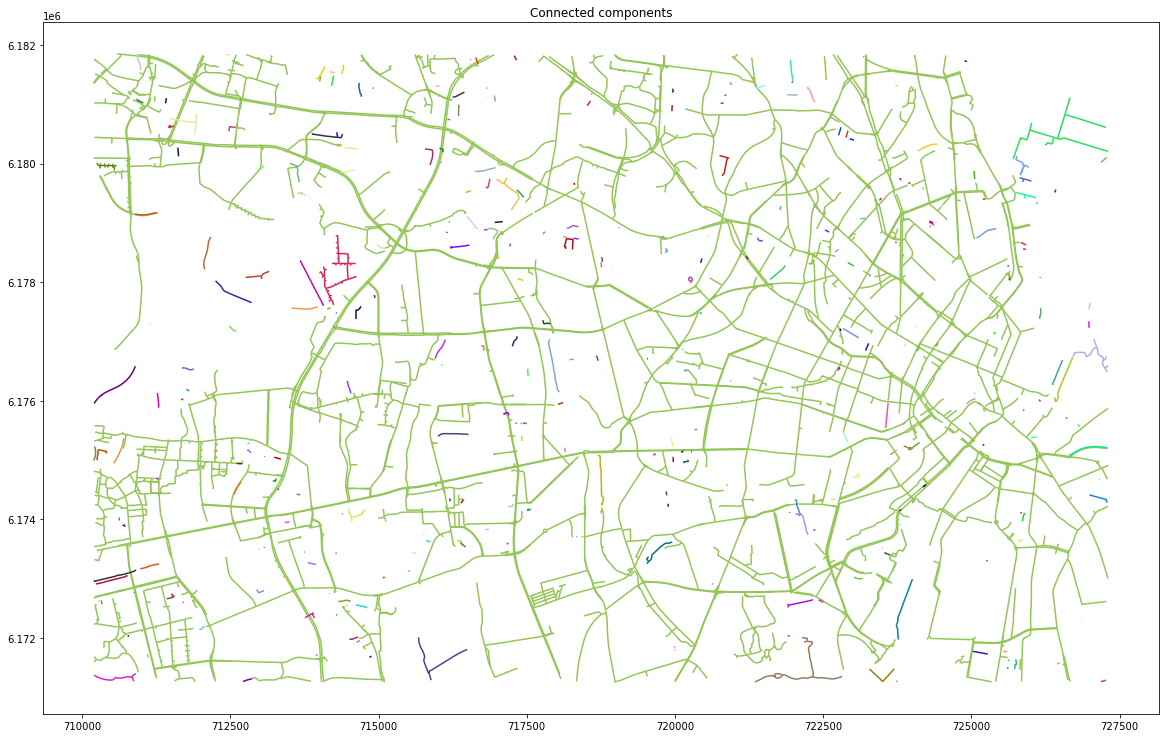

<AxesSubplot:>

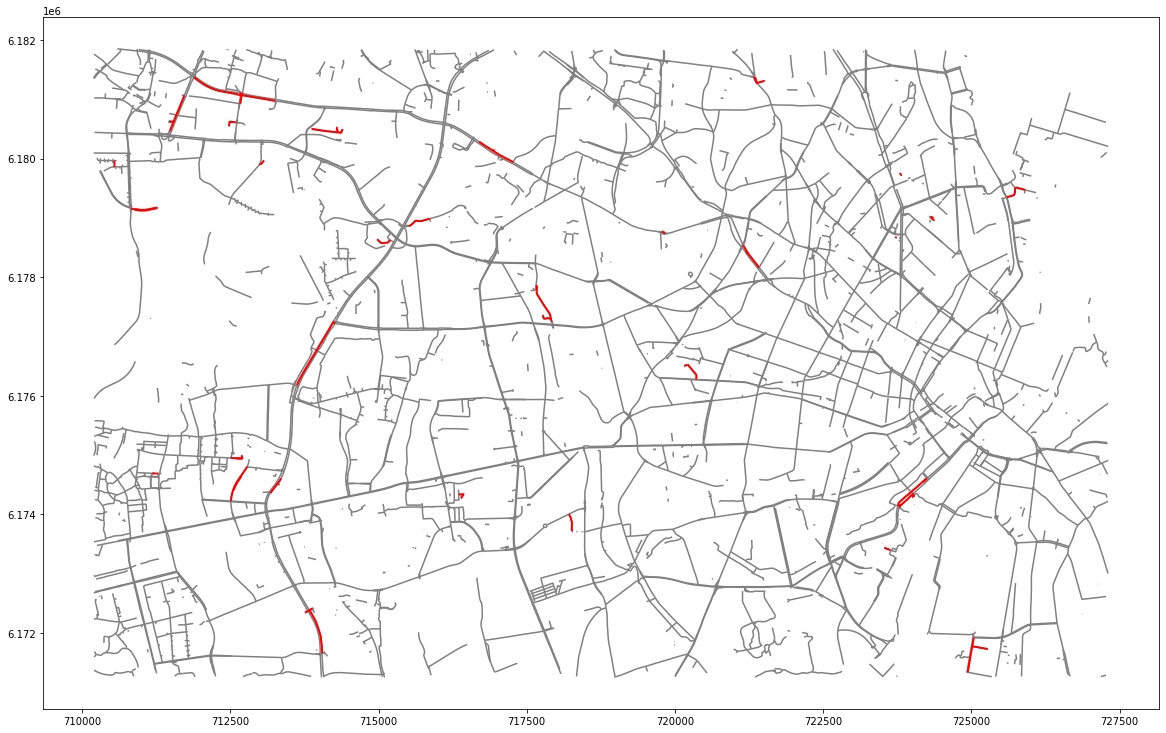

In [16]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)

issues, component_edges = ef.find_adjacent_components(components=osm_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='grey')
issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with unconnected components as well

The network in the study area consists of 195 unconnected ref_components.


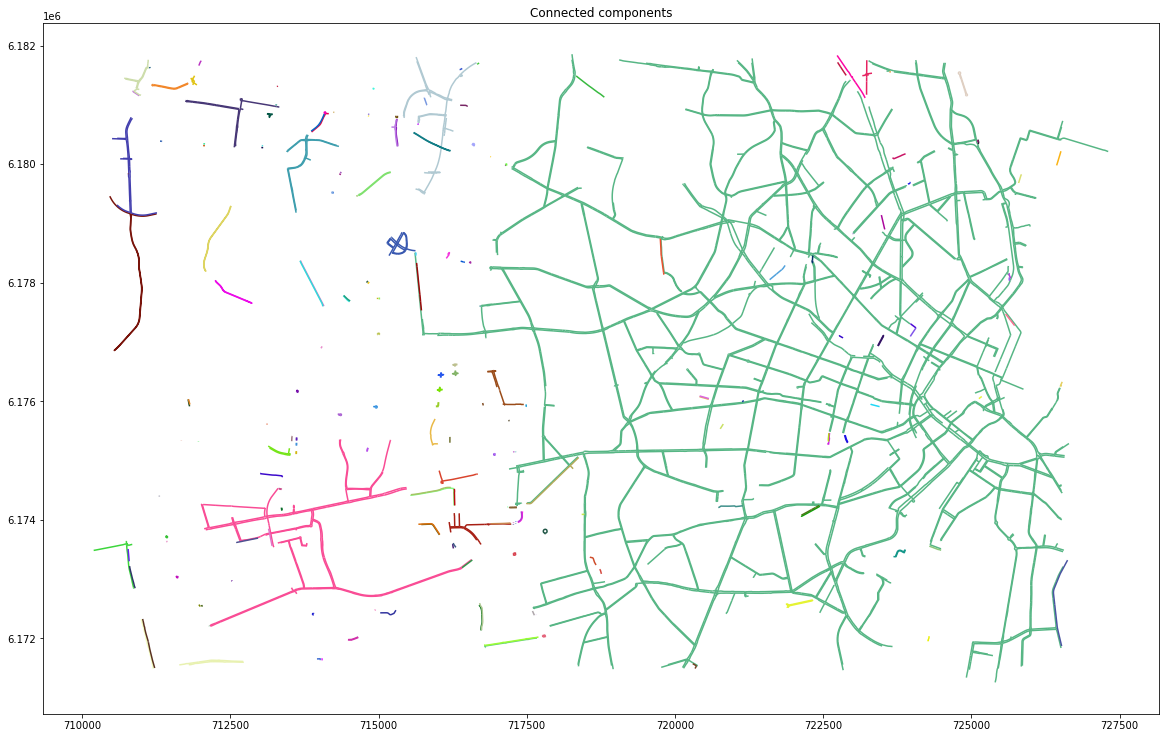

<AxesSubplot:>

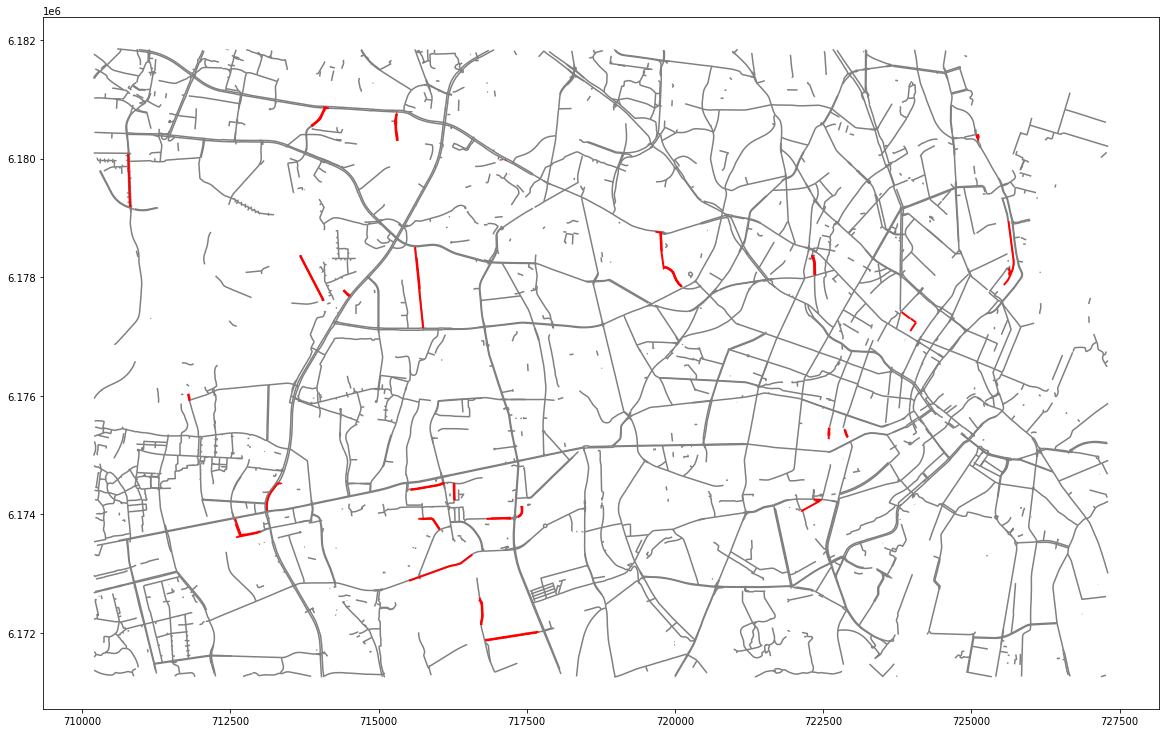

In [18]:

ref_components = ef.return_components(ref_simplified_graph)
print(f'The network in the study area consists of {len(ref_components)} unconnected ref_components.')

components_plot = ef.plot_components(ref_components)

issues, component_edges = ef.find_adjacent_components(components=ref_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='grey')
issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with unconnected ref_components as well

**Distribution of network length per component:**

In [ ]:
osm_components_length = {}

for i, c in enumerate(osm_components):

    c_length = 0

    for (u, v, l) in c.edges(data='length'):

        c_length += l
        
    osm_components_length[i] = c_length

osm_components_df = pd.DataFrame.from_dict(osm_components_length, orient='index')

osm_components_df.rename(columns={0:'component_length'}, inplace=True)

ax = osm_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (10,10))



ref_components_length = {}

for i, c in enumerate(ref_components):

    c_length = 0

    for (u, v, l) in c.edges(data='length'):

        c_length += l
        
    ref_components_length[i] = c_length

ref_components_df = pd.DataFrame.from_dict(ref_components_length, orient='index')

ref_components_df.rename(columns={0:'component_length'}, inplace=True)

ax = ref_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (10,10))

In [ ]:
osm_largest_cc = max(osm_components, key=len)

osm_largest_cc_length = 0

for (u, v, l) in osm_largest_cc.edges(data='length'):

        osm_largest_cc_length += l

osm_largest_cc_pct = osm_largest_cc_length / osm_components_df['component_length'].sum() * 100

print(f'The largest connected component in the OSM network contains {osm_largest_cc_pct:.2f} % of the network length.')

ref_largest_cc = max(ref_components, key=len)

ref_largest_cc_length = 0

for (u, v, l) in ref_largest_cc.edges(data='length'):

        ref_largest_cc_length += l

ref_largest_cc_pct = ref_largest_cc_length / ref_components_df['component_length'].sum() * 100

print(f'The largest connected component in the reference network contains {ref_largest_cc_pct:.2f} % of the network length.')

# TODO Add plot comparing the two. And maybe plot just the largest ones?

In [ ]:
# TODO: Calculate number of connected components compared to number of edges?

# basically just (len(edges.length.sum())) / len(components)

osm_edge_component_ratio = None
ref_edge_component_ratio = None

# TODO:  Compute number of cells with more than once component?

# Join component id to simplified edges - also to be used for later!

# Do a new spatial join between updated edges and grid
# Find a way of grouping per grid ID or something - just want the grid id and component labels

# TODO: Save component ID to edges - when doing the matching, identify edges which are in "different" components

**Count and plot all dangling nodes (dead ends):**

In [ ]:
# TODO: Compare number of dangling nodes

# total and per grid cell

# Compute number of dangling nodes - and plot them
osm_dangling_nodes = ef.get_dangling_nodes(osm_simplified_edges, osm_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
osm_simplified_nodes.plot(ax=ax, color='black', markersize=5)
osm_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

In [ ]:
# TODO: Compare number of dangling nodes

# total and per grid cell

# Compute number of dangling nodes - and plot them
ref_dangling_nodes = ef.get_dangling_nodes(ref_simplified_edges, ref_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
ref_simplified_nodes.plot(ax=ax, color='black', markersize=5)
ref_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

In [ ]:
# Add number of dangling nodes to grid

# Use function for counting from above but on dangling nodes
# Normalise per node count
# Drop column with org danglign node count - not needed anymore

# Plot - show the differences

**Identifying nodes that are placed within a distance of one meter, but do not share a common edge.**

Based on Barron et al., 2013.


In [ ]:
buffer_dist = 1
osm_snapping_issues = ef.find_network_gaps(osm_nodes,osm_edges, buffer_dist)

print(f'For the OSM data, there are {len(osm_snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

fig, axes = plt.subplots(ncols=1 ,nrows=len(osm_snapping_issues), figsize=(10,10))

axes = axes.flatten()

for s in range(len(osm_snapping_issues)):
    subset = osm_nodes.loc[osm_nodes.node_id.isin(osm_snapping_issues[s])]
    subset.plot(ax=axes[s])

    cx.add_basemap(
        ax=axes[s], 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )


In [ ]:
ref_snapping_issues = ef.find_network_gaps(ref_nodes,ref_edges, buffer_dist)

print(f'For the reference data, there are {len(ref_snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

fig, axes = plt.subplots(ncols=1 ,nrows=len(ref_snapping_issues), figsize=(10,10))

axes = axes.flatten()

for s in range(len(ref_snapping_issues)):
    subset = ref_nodes.loc[ref_nodes.node_id.isin(ref_snapping_issues[s])]
    subset.plot(ax=axes[s])

    cx.add_basemap(
        ax=axes[s], 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )


## Feasibility for Routing
- Can you use for routing?
- Differing shortest paths?

In [ ]:
# Compute grid cells connected in two different datasets

## Feature Matching

- Matched and non-matched edges - total and per grid cell (count or length?)
- Comparison of matched edges - do they aggree on core attributes?


What are core attributes? I am thinking whether it is lane/track? One or two-way - but how to account for differing digitising methods? Maybe protected/unprotected is enough?

For this - needs to be translated in the data attribute values

In [ ]:
# Matched and non-matched edges - total and per grid cell

In [ ]:
# TODO: Save results

all_results = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, snapping issues, danling node count, simplification outcome
# components (number of components, size distribution, issues with close unconnected components)

with open(f'../data/extrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)

# Save grid with results